In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
from glob import glob
import json
import h5py
from scipy import ndimage, interpolate
from tqdm import tqdm
import pandas as pd
from sympy import symbols, diff, lambdify, exp

from sociohydroInferer import *

# Testing given function

Given 
$$
\begin{align}
\phi_A(x) &= e^{-(x+a)^2} \\
\phi_B(x) &= e^{-(x-a)^2}
\end{align}
$$
can do we calculate the right features as what can be calculated analytically?

In [2]:
x = symbols('x')
offset = 1
a = exp(-(x + offset)**2)
b = exp(-(x - offset)**2)
o = 1-a-b

Ta = diff(o * diff(a, x) - a * diff(o, x), x)
kaa = diff(a * o * diff(a, x), x)
kab = diff(a * o * diff(b, x), x)
Γa = diff(a * o * diff(a, x, x, x), x)

Tb = diff(o * diff(b, x) - b * diff(o, x), x)
kbb = diff(b * o * diff(b, x), x)
kba = diff(b * o * diff(a, x), x)
Γb = diff(b * o * diff(b, x, x, x), x)

In [3]:
analytic_featuresA = lambdify(x, 0.1*Ta - kaa - kab - Γa, modules=["numpy"])
analytic_featuresB = lambdify(x, 0.1*Tb - kbb + kba - Γb, modules=["numpy"])

In [4]:
xx = np.linspace(-2*np.pi, 2*np.pi, 201)
tt = np.array([0, 1])
ϕa = np.exp(-(xx + offset)**2)[np.newaxis,]
ϕb = np.exp(-(xx - offset)**2)[np.newaxis,]

In [5]:
inferer = SociohydroInfer1D([ϕa], [ϕb], [xx], [tt],
                            t_dim=0, periodic=False)

In [6]:
fs = inferer.calc_features(inferer.ABts[0], inferer.xs[0])
numeric_featuresA = (fs[:, 0, 0, :4] * np.array([0.1, -1, -1, -1])).sum(axis=-1)
numeric_featuresB = (fs[:, 0, 1, :4] * np.array([0.1, -1, +1, -1])).sum(axis=-1)

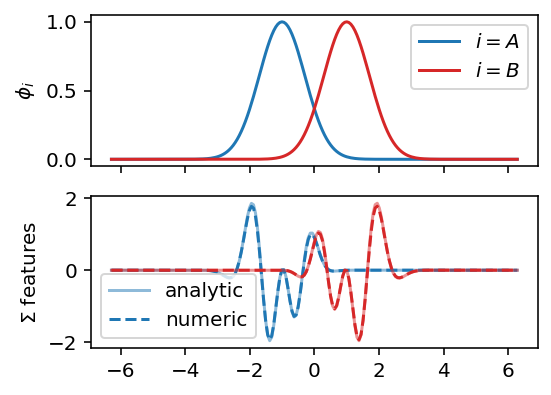

In [7]:
fig, ax = plt.subplots(2, dpi=144, figsize=(4, 3), sharex=True)

ax[0].plot(xx, ϕa[0], "C0", label=r"$i=A$")
ax[0].plot(xx, ϕb[0], "C3", label=r"$i=B$")
ax[0].set(ylabel=r"$\phi_i$")
ax[0].legend()

ax[1].plot(xx, analytic_featuresA(xx), "C0", label="analytic", alpha=0.5)
ax[1].plot(xx, numeric_featuresA, "C0--", label="numeric")
ax[1].plot(xx, analytic_featuresB(xx), "C3", alpha=0.5)
ax[1].plot(xx, numeric_featuresB, "C3--")
ax[1].set(ylabel=r"$\Sigma$ features")
# ax[1].set_box_aspect(1)
ax[1].legend()

# Test on 1D simulation data

In [2]:
parent_folder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro"

# non-linear pde solver data
# datafolder = "2024-06-19_SchellingData_nu0.4"
# linear pde solver data
datafolder = "2024-05-20_SchellingData"
# monte carlo data
# datafolder = "2024-05-15_schellingData/kappa0.40_delta0.64"

folder = os.path.join(parent_folder, datafolder)

datafile = glob(os.path.join(folder, "*hdf5"))[0]
paramfile = glob(os.path.join(folder, "*json"))[0]

with open(paramfile, "r") as p:
    params = json.load(p)

if "δ" not in params.keys():
    κm = -0.9
    κp = 0.1
    params["κ"] = κp
    params["δ"] = κm

if "nu" in params["savepath"]:
    ν = 0.4
    params["nu"] = ν
else:
    params["nu"] = 0.0

with h5py.File(datafile, "r") as d:
    keys = list(d.keys())
    xx = d[keys[0]]["x"][()]
    ϕ1 = np.zeros((len(keys), len(xx)))
    ϕ2 = np.zeros((len(keys), len(xx)))
    tt = np.zeros(len(keys))
    for kidx, key in enumerate(list(d.keys())):
        ϕ1[kidx] = d[key]["phiA"][()]
        ϕ2[kidx] = d[key]["phiB"][()]
        tt[kidx] = d[key]["t"][()]

params

{'savepath': '/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2024-05-20_SchellingData',
 'ϕB0': 0.25,
 'dt': 0.01,
 'Nt': 2000000,
 'temp': 0.1,
 'dx': 0.625,
 'snapshot': 1000,
 'ϕA0': 0.25,
 'Nx': 32,
 'α': 0.0,
 'Γ': 1.0,
 'filename': 'schellingSim',
 'κ': 0.1,
 'δ': -0.9,
 'nu': 0.0}

In [3]:
T = params["temp"]
Γ = params["Γ"]
k11 = 1
k22 = 1
k12 = (params["κ"] - params["δ"]) / 2
k21 = (params["κ"] + params["δ"]) / 2
nu = params["nu"]

coeffsA_true = np.array([T, -k11, -k12, -Γ, 0,        0, 0])
coeffsB_true = np.array([T, -k22, -k21, -Γ, k22 * nu, 0, 0])

coeffs_true = np.stack([coeffsA_true, coeffsB_true])
coeffs_true

array([[ 0.1, -1. , -0.5, -1. ,  0. ,  0. ,  0. ],
       [ 0.1, -1. ,  0.4, -1. ,  0. ,  0. ,  0. ]])

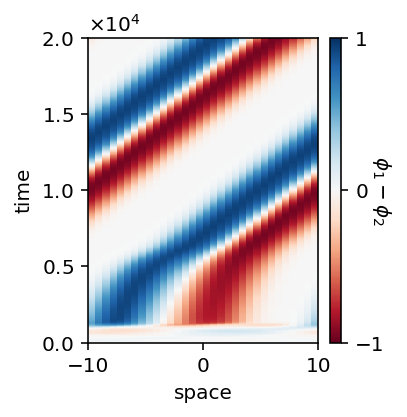

In [4]:
fig, ax = plt.subplots(1, dpi=144, sharey=True, figsize=(3, 3))
c = ax.pcolormesh(xx, tt, ϕ1-ϕ2, vmin=-1, vmax=1, cmap="RdBu",
                   rasterized=True)
cax = ax.inset_axes([1.05, 0.0, 0.05, 1.0])
cbar = fig.colorbar(c, cax=cax, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_ylabel(r"$\phi_1-\phi_2$", rotation=-90)

ax.set(xlabel="space", ylabel="time")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
ax.set(xlabel="space")

plt.tight_layout()

In [5]:
t_start = 10
t_end = 150

dx = xx[1] - xx[0]
ϕ1_interp = interpolate.make_interp_spline(np.concatenate([xx, (xx[-1]+dx)[np.newaxis]]),
                                           np.concatenate([ϕ1, ϕ1[:, 0][...,np.newaxis]], axis=-1),
                                           k=3, axis=-1, bc_type="periodic")
ϕ2_interp = interpolate.make_interp_spline(np.concatenate([xx, (xx[-1]+dx)[np.newaxis]]),
                                           np.concatenate([ϕ2, ϕ2[:, 0][...,np.newaxis]], axis=-1),
                                           k=3, axis=-1, bc_type="periodic")

# ϕ1_interp = interpolate.make_interp_spline(xx, ϕ1, k=5, axis=-1)
# ϕ2_interp = interpolate.make_interp_spline(xx, ϕ2, k=5, axis=-1)
x_new = np.linspace(xx.min(), xx.max()+dx, 101)

inferer = SociohydroInfer1D([ϕ1[t_start:t_end]], 
                            [ϕ2[t_start:t_end]], 
                            [xx], 
                            [tt[t_start:t_end]],
                            t_dim=0,
                            periodic=True,
                            diff_method="fd")

In [6]:
wl=5

dt = inferer.ts[0][1] - inferer.ts[0][0]

features = inferer.calc_features(inferer.ABts[0], inferer.xs[0], window_length=wl)
ABt_dt = np.gradient(inferer.ABts[0], dt, axis=1)
# ABt_dt = inferer.differentiate(inferer.ts[0], inferer.ABts[0], order=1, axis=-2,
#                                periodic=False, window_length=wl)  # ∂/∂t
ABt_dt_pred = (features * coeffs_true).sum(axis=-1)

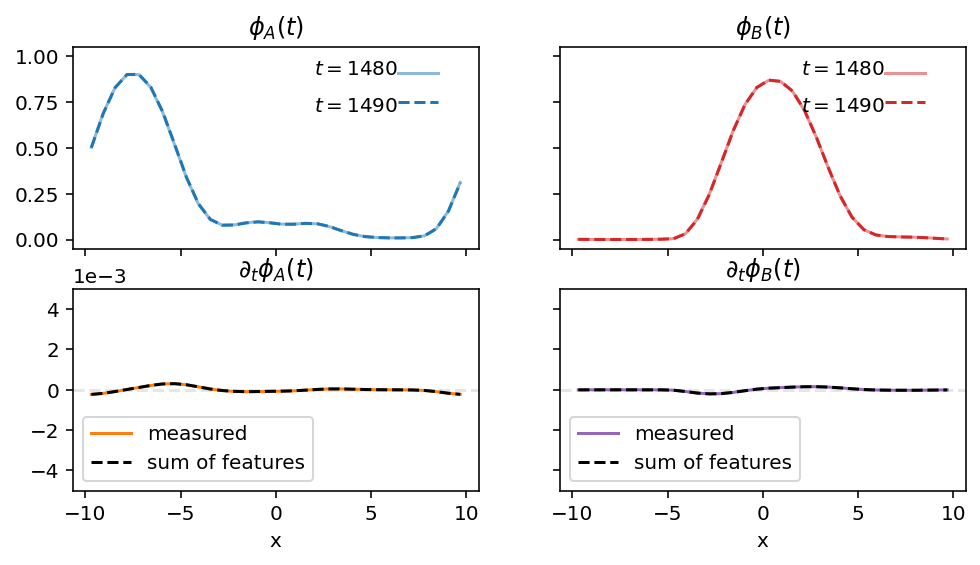

In [7]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey="row", dpi=144, figsize=(8, 4))

la_now, = ax[0, 0].plot(inferer.xs[0], inferer.ABts[0][:, 0, 0], "-", color="C0", alpha=0.5, label=" ")
la_next, = ax[0, 0].plot(inferer.xs[0], inferer.ABts[0][:, 1, 0], "--", color="C0", alpha=1.0, label=" ")
ax[0, 0].legend(loc="upper right", framealpha=0.0)
ax[0, 0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[0, 0].set(title="$\phi_A(t)$", ylim=[-0.05, 1.05])
texta_now = ax[0, 0].text(2, 0.9, rf"$t = {int(np.round(inferer.ts[0][0]))}$")
texta_next = ax[0, 0].text(2, 0.7, rf"$t = {int(np.round(inferer.ts[0][1]))}$")

lb_now, = ax[0, 1].plot(inferer.xs[0], inferer.ABts[0][:, 0, 1], "-", color="C3", alpha=0.5, label=" ")
lb_next, = ax[0, 1].plot(inferer.xs[0], inferer.ABts[0][:, 1, 1], "--", color="C3", alpha=1.0, label=" ")
ax[0, 1].legend(loc="upper right", framealpha=0.0)
ax[0, 1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[0, 1].set(title="$\phi_B(t)$")
textb_now = ax[0, 1].text(2, 0.9, rf"$t = {int(np.round(inferer.ts[0][0]))}$")
textb_next = ax[0, 1].text(2, 0.7, rf"$t = {int(np.round(inferer.ts[0][1]))}$")

la_dt, = ax[1, 0].plot(inferer.xs[0], ABt_dt[:, 0, 0], color="C1", label="measured")
la_dt_approx, = ax[1, 0].plot(inferer.xs[0], ABt_dt_pred[:, 0, 0], "k--", label="sum of features")
ax[1, 0].axhline(0, color="0.9", ls="--", zorder=-1)
ax[1, 0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[1, 0].set(title=r"$\partial_t \phi_A(t)$", xlabel="x", ylim=[-5e-3, 5e-3])
ax[1, 0].legend(loc="lower left")

lb_dt, = ax[1, 1].plot(inferer.xs[0], ABt_dt[:, 0, 1], color="C4", label="measured")
lb_dt_approx, = ax[1, 1].plot(inferer.xs[0], ABt_dt_pred[:, 0, 1], "k--", label="sum of features")
ax[1, 1].axhline(0, color="0.9", ls="--", zorder=-1)
ax[1, 1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[1, 1].set(title=r"$\partial_t \phi_B(t)$", xlabel="x")
ax[1, 1].legend(loc="lower left")

def animate(i):
    la_now.set_ydata(inferer.ABts[0][:, i, 0])
    texta_now.set_text(rf"$t = {int(np.round(inferer.ts[0][i]))}$")

    la_next.set_ydata(inferer.ABts[0][:, i+1, 0])
    texta_next.set_text(rf"$t = {int(np.round(inferer.ts[0][i+1]))}$")

    lb_now.set_ydata(inferer.ABts[0][:, i, 1])
    textb_now.set_text(rf"$t = {int(np.round(inferer.ts[0][i]))}$")

    lb_next.set_ydata(inferer.ABts[0][:, i+1, 1])
    textb_next.set_text(rf"$t = {int(np.round(inferer.ts[0][i+1]))}$")

    la_dt.set_ydata(ABt_dt[:, i, 0])
    la_dt_approx.set_ydata(ABt_dt_pred[:, i, 0])
    lb_dt.set_ydata(ABt_dt[:, i, 1])
    lb_dt_approx.set_ydata(ABt_dt_pred[:, i, 1])

    return [la_now, la_next, lb_now, lb_next, la_dt, la_dt_approx, lb_dt, lb_dt_approx]

anim = animation.FuncAnimation(fig, animate, frames=list(range(0, len(inferer.ts[0])-1, 2)),
                               interval=50, blit=True)
# anim.save(f"2024-06-03_1DSchelling_fields+features_tFinal{np.round(t[-1])}.mp4")
HTML(anim.to_html5_video())


100%|██████████| 30/30 [00:00<00:00, 37.51it/s]


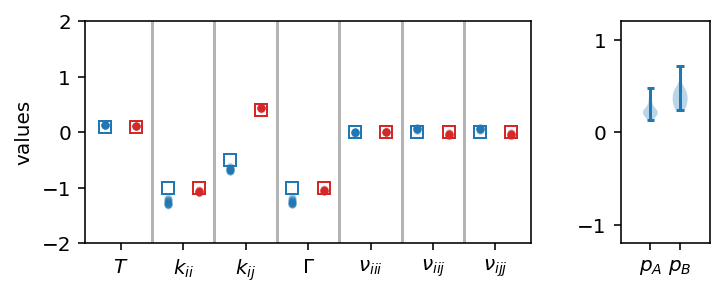

In [14]:
train_pct = 0.9
fig, ax = plt.subplots(dpi=144, figsize=(4, 2))
axp = ax.inset_axes([1.2, 0, 0.2, 1])
pAs = []
pBs = []
ntrials = 30
for i in tqdm(range(ntrials)):
    fitA, fitB, dAdt, dBdt, featA, featB, pA, pB = inferer.fit(train_pct,
                                                               regressor="linear",
                                                               alpha=0.01)
    ax.plot(np.arange(len(fitA.coef_)) - 0.25, fitA.coef_, "C0.", alpha=0.1)
    ax.plot(np.arange(len(fitB.coef_)) + 0.25, fitB.coef_, "C3.", alpha=0.1)
    pAs.append(pA)
    pBs.append(pB)
    # axp.plot([0, 1], [pA, pB], 'k.', alpha=0.1)

ax.plot(np.arange(len(fitA.coef_)) - 0.25, coeffsA_true, "s", mfc="white", mec="C0", zorder=-1)
ax.plot(np.arange(len(fitB.coef_)) + 0.25, coeffsB_true, "s", mfc="white", mec="C3", zorder=-1)

axp.violinplot([pAs, pBs], [0, 1])
axp.set(yticks=[-1, 0, 1], xticks=[0, 1],
        xticklabels=[r"$p_A$", r"$p_B$"])

for n in range(1, len(fitA.coef_)):
    ax.axvline(n - 0.5, color="0.7")

ax.set(xticks=range(len(fitA.coef_)),
       ylim=[-2, 2],
       xticklabels=[r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
                    r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"],
       ylabel="values")
axp.set(xlim=[-1, 2], ylim=[-1.2, 1.2]);
# axp.set_yticks([-1, 0, 1], loc="right")

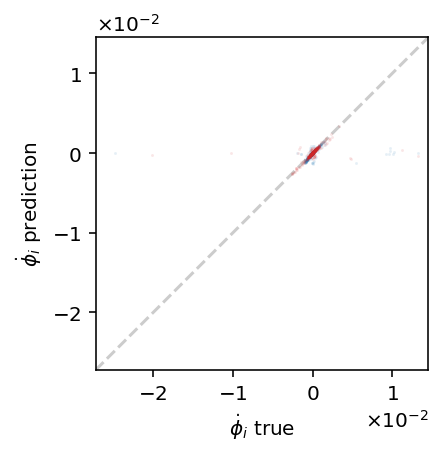

In [16]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.plot(dAdt["test"], fitA.predict(featA["test"]), "C0.", alpha=0.1, ms=1)
ax.plot(dBdt["test"], fitB.predict(featB["test"]), "C3.", alpha=0.1, ms=1)

ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0), useMathText=True)
ax.set(
    xlabel=r"$\dot{\phi}_i$ true",
    ylabel=r"$\dot{\phi}_i$ prediction",
    xlim=[1.1 * np.min([dAdt["test"].min(), dBdt["test"].min()]),
          1.1 * np.max([dAdt["test"].max(), dBdt["test"].max()])],
    ylim=[1.1 * np.min([dAdt["test"].min(), dBdt["test"].min()]),
          1.1 * np.max([dAdt["test"].max(), dBdt["test"].max()])]
)

ax.axline([0, 0], slope=1, ls="--", color="0.8", zorder=-1)

ax.set_aspect(1)

# Test on 2D simulation data

In [35]:
parent_folder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro"

# fipy solver data
datafolder = "2024-06-19_schelling2D2S_fipy"

folder = os.path.join(parent_folder, datafolder)

datafile = glob(os.path.join(folder, "*hdf5"))[0]
paramfile = glob(os.path.join(folder, "*json"))[0]

with open(paramfile, "r") as p:
    params = json.load(p)

with h5py.File(datafile, "r") as d:
    xx = np.unique(d["common"]["x"][()])
    yy = np.unique(d["common"]["y"][()])
    ϕ1 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    ϕ2 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    tt = np.zeros(params["nt"]+1)
    for kidx, key in enumerate(list(d.keys())[1:]):
        ϕ1[kidx] = np.reshape(d[key]["phi1"][()], (params["nx"], params["ny"]))
        ϕ2[kidx] = np.reshape(d[key]["phi2"][()], (params["nx"], params["ny"]))
        tt[kidx] = d[key]["t"][()]

nonzero_idx = np.where(ϕ1[:, 0, 0])[0]
ϕ1 = ϕ1[nonzero_idx]
ϕ2 = ϕ2[nonzero_idx]
tt = tt[nonzero_idx]

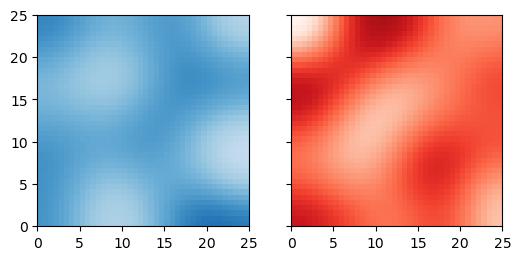

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].pcolormesh(xx, yy, ϕ1[-1], cmap="Blues", vmin=0.1, vmax=0.4)
ax[0].set_aspect(1)
ax[1].pcolormesh(xx, yy, ϕ2[-1], cmap="Reds", vmin=0.1, vmax=0.4)
ax[1].set_aspect(1)



In [37]:
t_start = 100
t_end = -1
inferer = SociohydroInfer2D([ϕ1[t_start:t_end]],
                            [ϕ2[t_start:t_end]],
                            [xx],
                            [yy],
                            [tt[t_start:t_end]])

In [48]:
dt = tt[1] - tt[0]
features = inferer.calc_features(inferer.ABts[0], inferer.xs[0], inferer.ys[0])
featA = features[..., 0, :]
At_dt = np.gradient(inferer.ABts[0], dt, axis=-2)[..., 0]
At_dt_notnan = np.all(~np.isnan(At_dt), axis=-1)
At_dt_notnan[-3:-1] = False
featA[At_dt_notnan].shape


(1520, 198, 7)

In [65]:
featA.shape

(40, 40, 198, 7)

In [57]:

test = sorted(np.random.choice(10, 7, replace=False))

In [85]:
T = params["temp"]
Γ = params["gamma"]
k11 = 1
k22 = 1
k12 = params["kp"] - params["km"]
k21 = params["kp"] + params["km"]
nu = params["nu"]

coeffsA_true = np.array([T, -k11, -k12, -Γ, 0,        0, 0])
coeffsB_true = np.array([T, -k22, -k21, -Γ, k22 * nu, 0, 0])

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


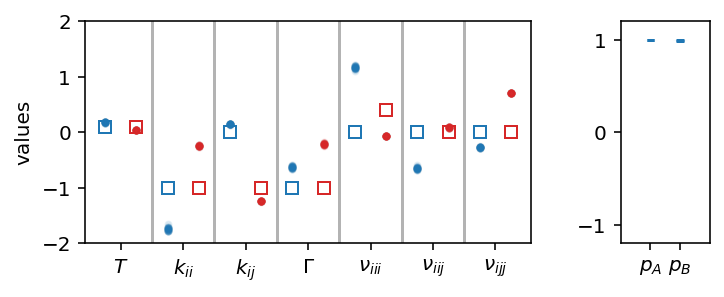

In [86]:
train_pct = 0.75
fig, ax = plt.subplots(dpi=144, figsize=(4, 2))
axp = ax.inset_axes([1.2, 0, 0.2, 1])
pAs = []
pBs = []
ntrials = 30
for i in tqdm(range(ntrials)):
    fitA, fitB, dAdt, dBdt, featA, featB, pA, pB = inferer.fit(train_pct)
    ax.plot(np.arange(len(fitA.coef_)) - 0.25, fitA.coef_, "C0.", alpha=0.1)
    ax.plot(np.arange(len(fitB.coef_)) + 0.25, fitB.coef_, "C3.", alpha=0.1)
    pAs.append(pA)
    pBs.append(pB)
    # axp.plot([0, 1], [pA, pB], 'k.', alpha=0.1)

ax.plot(np.arange(len(fitA.coef_)) - 0.25, coeffsA_true, "s", mfc="white", mec="C0", zorder=-1)
ax.plot(np.arange(len(fitB.coef_)) + 0.25, coeffsB_true, "s", mfc="white", mec="C3", zorder=-1)

axp.violinplot([pAs, pBs], [0, 1])
axp.set(yticks=[-1, 0, 1], xticks=[0, 1],
        xticklabels=[r"$p_A$", r"$p_B$"])

for n in range(1, len(fitA.coef_)):
    ax.axvline(n - 0.5, color="0.7")

ax.set(xticks=range(len(fitA.coef_)),
       ylim=[-2, 2],
       xticklabels=[r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
                    r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"],
       ylabel="values")
axp.set(xlim=[-1, 2], ylim=[-1.2, 1.2]);
# axp.set_yticks([-1, 0, 1], loc="right")

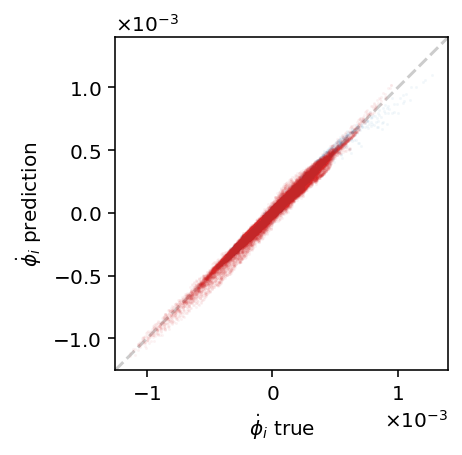

In [90]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.plot(dAdt["test"], fitA.predict(featA["test"]), "C0.", alpha=0.05, ms=1)
ax.plot(dBdt["test"], fitB.predict(featB["test"]), "C3.", alpha=0.05, ms=1)

ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0), useMathText=True)
ax.set(
    xlabel=r"$\dot{\phi}_i$ true",
    ylabel=r"$\dot{\phi}_i$ prediction",
    xlim=[1.1 * np.min([dAdt["test"].min(), dBdt["test"].min()]),
          1.1 * np.max([dAdt["test"].max(), dBdt["test"].max()])],
    ylim=[1.1 * np.min([dAdt["test"].min(), dBdt["test"].min()]),
          1.1 * np.max([dAdt["test"].max(), dBdt["test"].max()])]
)

ax.axline([0, 0], slope=1, ls="--", color="0.8", zorder=-1)

ax.set_aspect(1)

# Test on Census data

In [5]:
def get_data(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        capacity = np.zeros(x_grid.shape)
        if region == "county":
            white = d[ykey]["white_grid_county"][()]
            black = d[ykey]["black_grid_county"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_county"][:] + d[key]["black_grid_county"][:])
        elif region == "all":
            white = d[ykey]["white_grid_masked"][()]
            black = d[ykey]["black_grid_masked"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])

    ϕW = white / (1.1 * capacity)
    ϕB = black / (1.1 * capacity)

    return ϕW, ϕB, x_grid, y_grid

First try with just one dataset

In [3]:
datafile = "/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5"
years = [1980, 1990, 2000, 2010, 2020]

ϕW = []
ϕB = []
for year in years:
    w, b, xx, yy = get_data(datafile, year=year, region="all")
    ϕW.append(w)
    ϕB.append(b)

ϕW = np.asarray(ϕW)
ϕB = np.asarray(ϕB)
xx /= 1000
yy /= 1000

# smooth
ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW), 2.0, axes=[1, 2])
ϕW_smooth[np.isnan(ϕW)] = np.nan
ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB), 2.0, axes=[1, 2])
ϕB_smooth[np.isnan(ϕB)] = np.nan

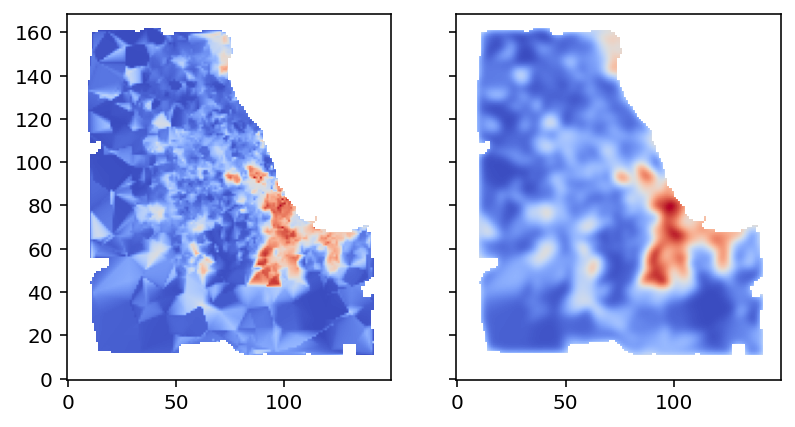

In [4]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
ax[0].imshow((ϕW - ϕB)[-1], origin="lower", cmap="coolwarm_r")
ax[1].imshow((ϕW_smooth - ϕB_smooth)[-1], origin='lower', cmap="coolwarm_r")

In [17]:
inferer = SociohydroInfer2D([ϕW_smooth],
                            [ϕB_smooth],
                            [np.unique(xx), np.unique(xx)],
                            [np.unique(yy), np.unique(yy)],
                            [np.array(years), np.array(years)],
                            t_dim = 0)

[Text(0.5, 1.0, '$\\partial_y \\phi_W$')]

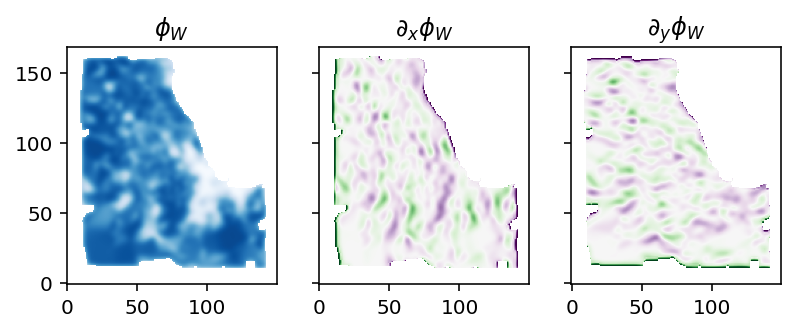

In [18]:
fig, ax = plt.subplots(1, 3, dpi=144, sharey=True)
ax[0].imshow(inferer.ABts[-1][..., -1, 0],
             origin="lower", vmin=0, vmax=1, cmap="Blues")
ax[0].set(title=r"$\phi_W$")
ax[1].imshow(inferer.differentiate(inferer.xs[-1], inferer.ABts[-1], order=1, periodic=False, axis=1)[..., -1, 0],
             origin="lower", vmin=-0.2, vmax=0.2, cmap="PRGn")
ax[1].set(title=r"$\partial_x \phi_W$")
ax[2].imshow(inferer.differentiate(inferer.ys[-1], inferer.ABts[-1], order=1, periodic=False, axis=0)[..., -1, 0],
             origin="lower", vmin=-0.2, vmax=0.2, cmap="PRGn")
ax[2].set(title=r"$\partial_y \phi_W$")

In [25]:
train_pct = 0.5
fitW, fitB, pW, pB = inferer.fit(train_pct)
print(pW)
print(pB)

-0.01427735598767649
0.155662593512865


In [27]:
fitB.coef_

array([-0.10787204,  0.60872534, -0.10781074,  0.57711828, -0.15142892,
       -0.37104706,  0.08970254])

Try to make inference take more than 1 field as input

In [51]:
datafiles = sorted(glob(os.path.join("/Users/danny/code/uchicago/sociohydro/data/raw/gridded", "*.hdf5")))
years = [1980, 1990, 2000, 2010, 2020]

ϕWs = []
ϕBs = []
xs = []
ys = []

for datafile in tqdm(datafiles):
    ϕW = []
    ϕB = []
    for year in years:
        w, b, xx, yy = get_data(datafile, year=year, region="all")
        ϕW.append(w)
        ϕB.append(b)

    ϕW = np.asarray(ϕW)
    ϕB = np.asarray(ϕB)
    xx /= 1000
    xs.append(np.unique(xx))
    yy /= 1000
    ys.append(np.unique(yy))

    # smooth
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW), 2.0, axes=[1, 2])
    ϕW_smooth[np.isnan(ϕW)] = np.nan
    ϕWs.append(ϕW_smooth)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB), 2.0, axes=[1, 2])
    ϕB_smooth[np.isnan(ϕB)] = np.nan
    ϕBs.append(ϕB_smooth)

ts = [np.asarray(years)] * len(xs)

 89%|████████▉ | 34/38 [00:01<00:00, 38.77it/s]/Users/danny/code/uchicago/sociohydro/inference/infer_utils.py:67: RuntimeWarning: invalid value encountered in divide
  ϕW = white / (1.1 * capacity)
/Users/danny/code/uchicago/sociohydro/inference/infer_utils.py:68: RuntimeWarning: invalid value encountered in divide
  ϕB = black / (1.1 * capacity)
100%|██████████| 38/38 [00:01<00:00, 29.10it/s]


In [52]:
inferer = SociohydroInfer2D(ϕWs, ϕBs, xs, ys, ts,
                            t_dim = 0)

In [53]:
train_pct = 0.5
fitW, fitB, pW, pB = inferer.fit(train_pct)
print(pW)
print(pB)

-0.0019547959569683453
0.042974252808374205


It's bad, but it works!

# Test with ACS data

In [2]:
datafolder = "/project/vitelli/dsseara/schelling/data/yearly/raw/gridded"
datafiles = sorted(glob(os.path.join(datafolder, "*hdf5")))

In [3]:
def get_data(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        capacity = np.zeros(x_grid.shape)
        if region == "county":
            white = d[ykey]["white_grid_county"][()]
            black = d[ykey]["black_grid_county"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_county"][:] + d[key]["black_grid_county"][:])
        elif region == "all":
            white = d[ykey]["white_grid_masked"][()]
            black = d[ykey]["black_grid_masked"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])

    ϕW = white / (1.1 * capacity)
    ϕB = black / (1.1 * capacity)

    return ϕW, ϕB, x_grid, y_grid

In [8]:
σ = 2.0
ϕWs = []
ϕBs = []
xs = []
ys = []
ts = []
ts_interp = []

# LA, Fulton, Cook, Wayne, NYC, Harris
# idxs = [3, 14, 15, 18, 22, 33]
idxs = [15]
for idx in idxs:
    datafile = datafiles[idx]

    # get times and interp times
    with h5py.File(datafile, "r") as d:
        t = np.array([int(k) for k in list(d.keys())])
    t_interp = np.linspace(t[0], t[-1], 101)
    
    ϕW = []
    ϕB = []
    for year in t:
        w, b, xx, yy = get_data(datafile, year=year, region="all")
        ϕW.append(w)
        ϕB.append(b)

    # white demographic data
    ϕW = np.asarray(ϕW)
    ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW),
                                        σ, axes=[1, 2])
    cubicW = interpolate.interp1d(t, ϕW_smooth, axis=0, kind="cubic")
    ϕW_smooth_interp = cubicW(t_interp)
    ϕW_smooth_interp[:, np.any(np.isnan(ϕW), axis=0)] = np.nan
    ϕWs.append(ϕW_smooth_interp)

    # black demographic data
    ϕB = np.asarray(ϕB)
    ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB),
                                        σ, axes=[1, 2])
    cubicB = interpolate.interp1d(t, ϕB_smooth, axis=0, kind="cubic")
    ϕB_smooth_interp = cubicB(t_interp)
    ϕB_smooth_interp[:, np.any(np.isnan(ϕB), axis=0)] = np.nan
    ϕBs.append(ϕB_smooth_interp)

    # x position data
    xx /= 1000
    xs.append(np.unique(xx))

    # y position data
    yy /= 1000
    ys.append(np.unique(yy))

    # t data
    ts.append(t)
    ts_interp.append(t_interp)

Test interpolating in time

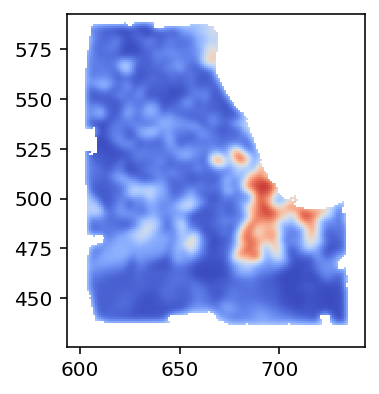

In [10]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
ax.set_aspect(1)
sc_idx = 0

c = ax.pcolormesh(xs[sc_idx], ys[sc_idx], (ϕWs[sc_idx] - ϕBs[sc_idx])[0], cmap="coolwarm_r")

def animate(i):
    c.set_array((ϕWs[sc_idx] - ϕBs[sc_idx])[i].flatten())
    return [c,]

anim = animation.FuncAnimation(fig, animate, frames=len(ts_interp[0]),
                               interval=100, blit=True)

HTML(anim.to_html5_video())

In [11]:
inferer = SociohydroInfer2D(ϕWs, ϕBs,
                            xs, ys, ts_interp,
                            t_dim = 0)

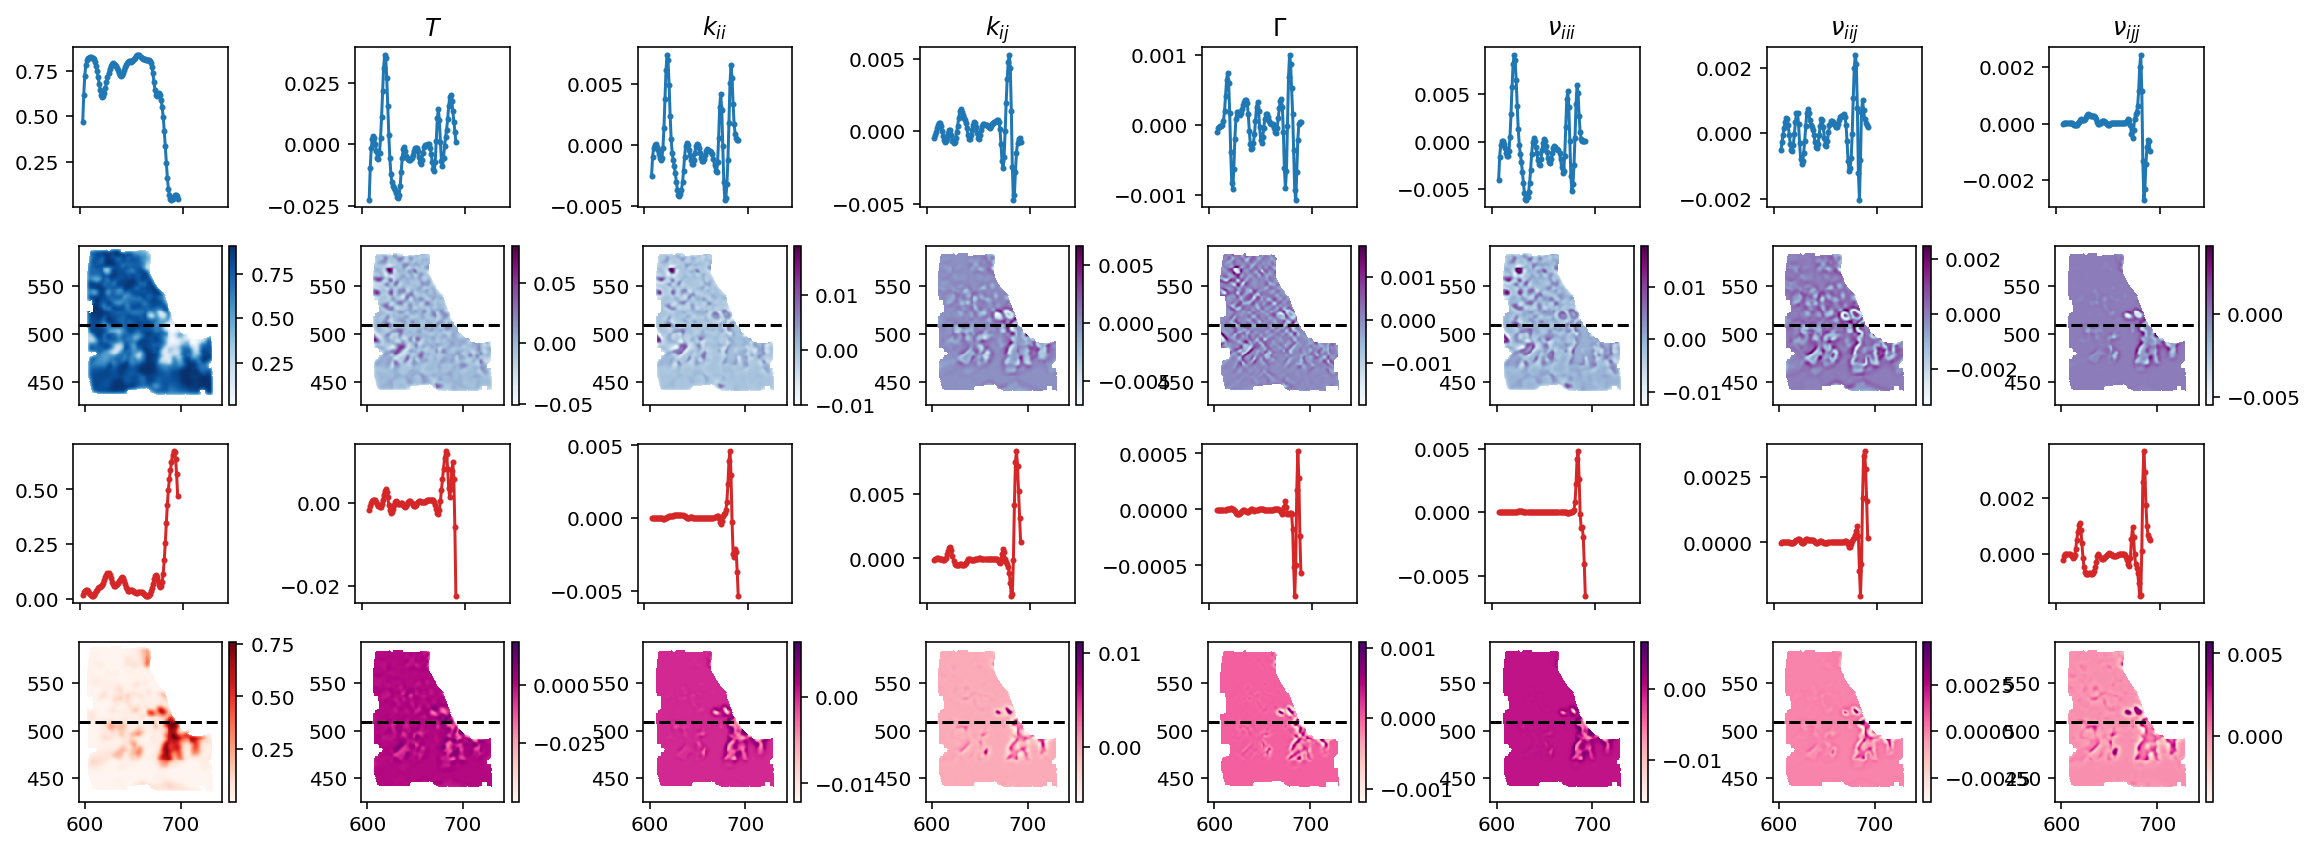

In [17]:
sc_idx = 0

features = inferer.calc_features(inferer.ABts[sc_idx], inferer.xs[sc_idx], inferer.ys[sc_idx])
fig, ax = plt.subplots(4, 8, dpi=144, figsize=(16,6),
                       sharex="col")

feat_max = np.nanmax(np.abs(features[..., -1, :, :]), axis=(0, 1))
midy = len(inferer.ys[sc_idx])//2

# plot White population
ax[0, 0].plot(inferer.xs[sc_idx], inferer.ABts[sc_idx][midy, :, -1, 0],
              "C0-o", ms=2)
f = ax[1, 0].pcolormesh(inferer.xs[sc_idx],
                        inferer.ys[sc_idx],
                        inferer.ABts[sc_idx][..., -1, 0],
                        cmap="Blues",
                        rasterized=True)
cax = ax[1, 0].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(f, cax=cax, ax=ax[1, 0])
ax[1, 0].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")
ax[1, 0].set_aspect(1)

# plot Black population
ax[2, 0].plot(inferer.xs[sc_idx], inferer.ABts[sc_idx][midy, :, -1, 1],
              "C3-o", ms=2)
f = ax[3, 0].pcolormesh(inferer.xs[sc_idx],
                        inferer.ys[sc_idx],
                        inferer.ABts[sc_idx][..., -1, 1],
                        cmap="Reds",
                        rasterized=True)
cax = ax[3, 0].inset_axes([1.05, 0, 0.05, 1])
fig.colorbar(f, cax=cax, ax=ax[3, 0])
ax[3, 0].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")
ax[3, 0].set_aspect(1)

for feat_idx in range(7):
    ax[0, feat_idx+1].plot(inferer.xs[sc_idx], features[midy, :, -1, 0, feat_idx],
                         "C0-o", ms=2)
    f = ax[1, feat_idx+1].pcolormesh(inferer.xs[sc_idx],
                                           inferer.ys[sc_idx],
                                           features[..., -1, 0, feat_idx],
                                           # vmin=-feat_max[group_idx, feat_idx],
                                           # vmax=+feat_max[group_idx, feat_idx],
                                           cmap="BuPu", rasterized=True)
    ax[1, feat_idx+1].set_aspect(1)
    cax = ax[1, feat_idx+1].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(f, cax=cax, ax=ax[1, feat_idx+1])
    
    ax[1, feat_idx+1].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")

    ax[2, feat_idx+1].plot(inferer.xs[sc_idx], features[midy, :, -1, 1, feat_idx],
                         "C3-o", ms=2)
    f = ax[3, feat_idx+1].pcolormesh(inferer.xs[sc_idx],
                                           inferer.ys[sc_idx],
                                           features[..., -1, 1, feat_idx],
                                           # vmin=-feat_max[group_idx, feat_idx],
                                           # vmax=+feat_max[group_idx, feat_idx],
                                           cmap="RdPu", rasterized=True)
    ax[3, feat_idx+1].set_aspect(1)
    cax = ax[3, feat_idx+1].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(f, cax=cax, ax=ax[3, feat_idx+1])
    midy = len(inferer.ys[sc_idx])//2
    
    ax[3, feat_idx+1].axhline(inferer.ys[sc_idx][midy], color="k", ls="--")

ax[0, 0+1].set(title=r"$T$")
ax[0, 1+1].set(title=r"$k_{ii}$")
ax[0, 2+1].set(title=r"$k_{ij}$")
ax[0, 3+1].set(title=r"$\Gamma$")
ax[0, 4+1].set(title=r"$\nu_{iii}$")
ax[0, 5+1].set(title=r"$\nu_{iij}$")
ax[0, 6+1].set(title=r"$\nu_{ijj}$")

plt.tight_layout()

fig.savefig("/project/vitelli/dsseara/schelling/data/2024-06-05_inference/2024-06-26_features_Illinois_Cook_2021.pdf")

In [13]:
names = [r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
         r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"]
coeffs = np.array([])
coeff_names = np.array([])
coeff_group = np.array([])
pWs = []
pBs = []

ntrials = 30
train_pct = 0.9
for trial in tqdm(range(ntrials)):
    fitW, fitB, _, _, _, _, pW, pB = inferer.fit(train_pct)
    coeffs = np.append(coeffs, list(fitW.coef_))
    coeffs = np.append(coeffs, list(fitB.coef_))
    coeff_names = np.append(coeff_names, names*2)
    coeff_group = np.append(coeff_group, ["W"]*len(fitW.coef_))
    coeff_group = np.append(coeff_group, ["B"]*len(fitW.coef_))
    pWs.append(pW)
    pBs.append(pB)


coef_df = pd.DataFrame({"val": coeffs,
                        "name": coeff_names,
                        "demo": coeff_group})

100%|██████████| 30/30 [02:54<00:00,  5.83s/it]


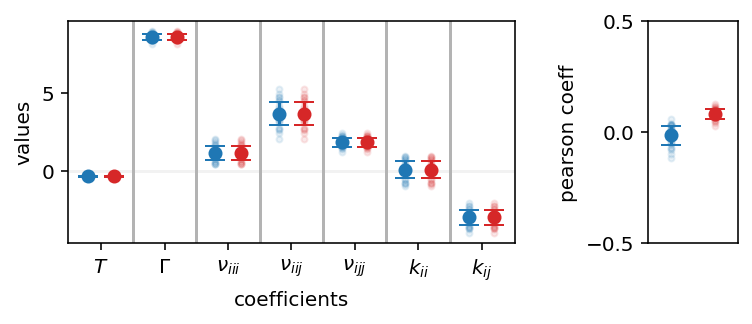

In [14]:
fig, ax = plt.subplots(dpi=144, figsize=(4,2))

for demo_code, color, offset in zip(["W", "B"], ["C0", "C3"], [-0.2, +0.2]):
    demo_df = coef_df.loc[coef_df["demo"]==demo_code][["val", "name"]]
    xvals = pd.Categorical(demo_df.name).codes+offset
    
    ax.plot(xvals, demo_df.val, ".", color=color, alpha=0.1)
    ax.errorbar(np.arange(7)+offset,
                demo_df.groupby("name").mean().reset_index().val.values,
                yerr=demo_df.groupby("name").std().reset_index().val.values,
                fmt="o", color=color, capsize=5)


ax.set(xticks=range(7), xticklabels=pd.Categorical(coef_df.name).categories.values,
       ylabel="values", xlabel="coefficients");
for n in range(1, len(coef_df.name.unique())):
    ax.axvline(n - 0.5, color="0.7")

ax.axhline(0, color="0.95", zorder=-1)


axp = ax.inset_axes([1.3, 0, 0.2, 1])
axp.plot([0] * len(pWs), pWs, "C0.", alpha=0.1)
axp.errorbar([0], np.mean(pWs), yerr=np.std(pWs),
             fmt="o", color="C0", capsize=5)
axp.plot([1] * len(pBs), pBs, "C3.", alpha=0.1)
axp.errorbar([1], np.mean(pBs), yerr=np.std(pBs),
             fmt="o", color="C3", capsize=5)
axp.set(xlim=[-0.5, 1.5], xticks=[],
        ylim=[-0.5, 0.5], yticks=[-0.5, 0, 0.5],
        ylabel="pearson coeff")

savefolder = "/project/vitelli/dsseara/schelling/data/2024-06-05_inference/"
# fig.savefig(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}.pdf"),
#            bbox_inches="tight")

In [11]:
coef_df.groupby(["name", "demo"]).mean().reset_index()

,name,demo,val
0,$T$,B,0.092080
1,$T$,W,0.096690
2,$\Gamma$,B,0.474850
3,$\Gamma$,W,0.497152
4,$\nu_{iii}$,B,0.121735
5,$\nu_{iii}$,W,-0.006106
6,$k_{ii}$,B,-0.434879
7,$k_{ii}$,W,0.064444
8,$k_{ij}$,B,-0.361575
9,$k_{ij}$,W,-0.081779


In [12]:
coef_df.to_csv(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}.csv"), index=False)
coef_df.groupby(["name", "demo"]).mean().reset_index().to_csv(os.path.join(savefolder, f"2024-06-27_coefficients_allFeatures_trainPct{train_pct}_sigma{σ}_mean.csv"),
                                                             index=False)